# Homework 04: Building CNNs for Image Classification

## Due: Midnight on February 15 (with 2-hour grace period) and worth 85 points

In this assignment, you will take your first steps into designing and training convolutional neural networks (CNNs) for image classification. Starting from a simple baseline, you will experiment with modifications that reflect the kinds of design choices practitioners face every day. Along the way, you’ll see how architecture, hyperparameters, normalization, pooling strategies, and learning rate schedules can each shape a model’s performance.

The problems are organized to build on each other:

1. **Hyperparameters:** Begin with a baseline CNN and try variations in learning rate, layer width, depth, and dropout.
2. **Batch Normalization:** Add normalization after convolutional layers to stabilize training and speed convergence.
3. **Global Average Pooling:** Replace the flatten-and-dense head with a modern pooling layer, reducing parameters and improving generalization.
4. **ReduceLROnPlateau:** Explore a widely used learning rate scheduler that adapts when validation progress slows.
5. **Very Deep CNN:** Finally, run a VGG-16–style model to observe how deeper networks behave compared to smaller ones.

By the end of this homework, you will have hands-on experience with both classical and modern CNN design strategies, a sense of how different components affect learning, and a toolkit of techniques that will serve you in future image processing projects.

There are 10 graded questions, worth 8 points each, with 5 points free if you complete all of the graded questions in the homework.


## 1. Setup and Data Loading


In [16]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import os,time,random,kagglehub

import tensorflow as tf
from tensorflow.keras import layers, Input, models, callbacks, regularizers,initializers
from tensorflow.keras.callbacks import Callback,EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical, load_img, img_to_array
from tensorflow.keras.optimizers import Adam,AdamW
from tensorflow.keras.optimizers.schedules import CosineDecay, ExponentialDecay
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from tensorflow.keras.layers import Dense,Input,Dropout,Flatten,MaxPooling2D,Conv2D,SeparableConv2D,GlobalAveragePooling2D,GlobalMaxPooling2D,BatchNormalization,Activation

from sklearn.model_selection import train_test_split

# utility code

# -------------------------
# Reproducibility settings
# -------------------------

random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
tf.keras.utils.set_random_seed(random_seed)

def format_hms(seconds):
    return time.strftime("%H:%M:%S", time.gmtime(seconds))

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppresses INFO and WARNING messages

### Utility function to plot learning curves and keep track of all results

- Call `print_results()` to see listing of all results logged so far

In [2]:

def plot_learning_curves(hist, title, verbose=True):

    val_losses = hist.history['val_loss']
    min_val_loss = min(val_losses)
    min_val_epoch = val_losses.index(min_val_loss)
    val_acc_at_min_loss = hist.history['val_accuracy'][min_val_epoch]

    epochs = range(1, len(val_losses) + 1)  # epoch numbers starting at 1

    fig, axs = plt.subplots(2, 1, figsize=(8, 8), sharex=True)

    # --- Loss Plot ---
    axs[0].plot(epochs, hist.history['loss'], label='train loss')
    axs[0].plot(epochs, hist.history['val_loss'], label='val loss')
    axs[0].scatter(min_val_epoch + 1, min_val_loss, color='red', marker='x', s=50, label='min val loss')
    axs[0].set_title(f'{title} - Categorical Cross-Entropy Loss')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    axs[0].grid(True)

    # --- Accuracy Plot ---
    axs[1].plot(epochs, hist.history['accuracy'], label='train acc')
    axs[1].plot(epochs, hist.history['val_accuracy'], label='val acc')
    axs[1].scatter(min_val_epoch + 1, val_acc_at_min_loss, color='red', marker='x', s=50, label='acc @ min val loss')
    axs[1].set_title(f'{title} - Accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()
    axs[1].grid(True)
    axs[1].set_ylim(0, 1.05)

    plt.tight_layout()
    plt.show()

    if verbose:
        print(f"Final Training Loss:            {hist.history['loss'][-1]:.4f}")
        print(f"Final Training Accuracy:        {hist.history['accuracy'][-1]:.4f}")
        print(f"Final Validation Loss:          {hist.history['val_loss'][-1]:.4f}")
        print(f"Final Validation Accuracy:      {hist.history['val_accuracy'][-1]:.4f}")
        print(f"Minimum Validation Loss:        {min_val_loss:.4f} (Epoch {min_val_epoch + 1})")
        print(f"Validation Accuracy @ Min Loss: {val_acc_at_min_loss:.4f}")

    results[title] = (val_acc_at_min_loss,min_val_epoch + 1)

results = {}

def print_results():
    for title, (acc, ep) in sorted(results.items(),
                                   key=lambda kv: kv[1][0],   # kv[1] is (acc, epoch); [0] is acc
                                   reverse=True
                                  ):
        print(f"{title:<40}\t{acc:.4f}\t{ep}")

###  Wrapper for training and testing

#### Assumptions:   
- Early stopping is default, add other callbacks as needed
- Testing and training sets already defined, accessed here as global variables

###  Wrapper for training and testing

#### Assumptions:   
- Early stopping is default, add other callbacks as needed
- Training and testing sets already defined, accessed here as global variables

In [3]:
# Uses globals: train_ds, val_ds, test_ds

def train_and_test(model,
                   epochs        = 500,
                   lr_schedule   = 1e-3,
                   optimizer     = "Adam",
                   title         = "Learning Curves",
                   batch_size    = 64,                # kept for API compatibility; ignored if datasets are batched
                   use_early_stopping = True,
                   patience      = 10,
                   min_delta     = 0.0001,
                   callbacks     = [],
                   verbose       = 0,
                   return_history = False
                  ):

    print(f"\n{title}\n")

    # Choose optimizer
    if optimizer == "Adam":
        opt = Adam(learning_rate=lr_schedule)
    else:
        opt = optimizer

    # Compile
    model.compile(
        optimizer=opt,
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )

    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=patience,
        min_delta=min_delta,
        restore_best_weights=True,
        verbose=verbose
    )

    cbs = ([early_stop] if use_early_stopping else []) + callbacks

    start = time.time()

    # Fit on tf.data datasets (already batched)
    history = model.fit(
        train_ds,
        epochs=epochs,
        validation_data=val_ds,
        callbacks=cbs,
        verbose=verbose
    )

    # Determine best validation accuracy
    if use_early_stopping and hasattr(early_stop, "best_epoch") and early_stop.best_epoch is not None:
        best_epoch = early_stop.best_epoch
        best_acc   = history.history['val_accuracy'][best_epoch]
    else:
        best_epoch = int(np.argmax(history.history['val_accuracy']))
        best_acc   = history.history['val_accuracy'][best_epoch]

    plot_learning_curves(history, title=title)

    # Evaluate on tf.data test set
    test_loss, test_accuracy = model.evaluate(test_ds, verbose=0)

    print(f"\nTest Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"\nValidation-Test Gap (accuracy): {abs(best_acc - test_accuracy):.6f}")

    end = time.time()
    print(f"\nExecution Time: " + format_hms(end-start))

    if return_history:
        return history


### Load the Intel Image Classification Dataset  



In [4]:
path      = kagglehub.dataset_download("puneet6060/intel-image-classification")
train_dir = os.path.join(path, "seg_train/seg_train")
test_dir  = os.path.join(path, "seg_test/seg_test")

Using Colab cache for faster access to the 'intel-image-classification' dataset.


In [5]:
import os
import numpy as np
import tensorflow as tf

AUTOTUNE = tf.data.AUTOTUNE

def list_files_and_labels(directory, class_names=None, exts=(".jpg", ".jpeg", ".png")):
    """
    Returns:
      filepaths: np.array[str]
      labels:    np.array[int32]
      class_names_used: list[str] in deterministic order
    """
    if class_names is None:
        class_names = sorted(
            d for d in os.listdir(directory)
            if os.path.isdir(os.path.join(directory, d))
        )
    else:
        # keep only classes that exist in this directory, preserve given order
        class_names = [c for c in class_names if os.path.isdir(os.path.join(directory, c))]

    class_to_idx = {name: idx for idx, name in enumerate(class_names)}

    filepaths = []
    labels = []

    for cname in class_names:
        folder = os.path.join(directory, cname)
        for fname in sorted(os.listdir(folder)):  # deterministic within class
            if fname.lower().endswith(exts):
                filepaths.append(os.path.join(folder, fname))
                labels.append(class_to_idx[cname])

    return np.array(filepaths), np.array(labels, dtype=np.int32), class_names


def stratified_split_indices(y, val_frac=0.2, seed=42):
    """
    Deterministic stratified split over indices.
    Returns: train_idx, val_idx (np arrays)
    """
    rng = np.random.default_rng(seed)
    y = np.asarray(y)
    n = len(y)

    train_idx_list = []
    val_idx_list = []

    classes = np.unique(y)
    for c in classes:
        idx = np.flatnonzero(y == c)
        rng.shuffle(idx)
        n_val = int(np.floor(len(idx) * val_frac))
        val_idx_list.append(idx[:n_val])
        train_idx_list.append(idx[n_val:])

    train_idx = np.concatenate(train_idx_list)
    val_idx = np.concatenate(val_idx_list)

    # Optional: shuffle each split deterministically so batches mix classes
    rng.shuffle(train_idx)
    rng.shuffle(val_idx)

    return train_idx, val_idx


def make_image_dataset(filepaths, labels, img_size=(150, 150), batch_size=32,
                       shuffle=False, seed=42, cache_to_disk=None):
    """
    Builds a tf.data.Dataset that loads images lazily from disk.
    - filepaths: np array of strings
    - labels:    np array of int32
    """
    ds = tf.data.Dataset.from_tensor_slices((filepaths, labels))

    if shuffle:
        # shuffle file *references* (cheap), not image tensors
        ds = ds.shuffle(buffer_size=len(filepaths), seed=seed, reshuffle_each_iteration=True)

    def _load_and_preprocess(path, label):
        # read bytes -> decode -> resize -> float32 in [0,1]
        img_bytes = tf.io.read_file(path)
        img = tf.image.decode_image(img_bytes, channels=3, expand_animations=False)
        img = tf.image.resize(img, img_size, method="bilinear")
        img = tf.cast(img, tf.float32) / 255.0
        return img, label

    ds = ds.map(_load_and_preprocess, num_parallel_calls=AUTOTUNE)

    if cache_to_disk is not None:
        # Disk caching avoids RAM blowups; /tmp is fine in Colab
        ds = ds.cache(cache_to_disk)

    ds = ds.batch(batch_size).prefetch(AUTOTUNE)
    return ds


# -------------------------
# Example usage for Intel dataset
# -------------------------

IMG_SIZE    = (150, 150)
INPUT_SHAPE = IMG_SIZE + (3,)
BATCH_SIZE  = 32
VAL_FRAC    = 0.2
SEED        = random_seed  # use your existing seed

# 1) List train files/labels deterministically
train_files, train_labels, class_names = list_files_and_labels(train_dir)

num_classes = len(class_names)

# 2) Stratified deterministic split of *indices* (no images loaded)
train_idx, val_idx = stratified_split_indices(train_labels, val_frac=VAL_FRAC, seed=SEED)

# 3) Slice file lists
files_train = train_files[train_idx]
y_train     = train_labels[train_idx]
files_val   = train_files[val_idx]
y_val       = train_labels[val_idx]

# 4) Build datasets (lazy image loading)
train_ds = make_image_dataset(files_train, y_train, img_size=IMG_SIZE,
                              batch_size=BATCH_SIZE, shuffle=True, seed=SEED,
                              cache_to_disk=None)  # or "/tmp/train_cache"

val_ds   = make_image_dataset(files_val, y_val, img_size=IMG_SIZE,
                              batch_size=BATCH_SIZE, shuffle=False,
                              cache_to_disk=None)  # or "/tmp/val_cache"

# 5) Test set: keep same class mapping as train
test_files, test_labels, _ = list_files_and_labels(test_dir, class_names=class_names)
test_ds = make_image_dataset(test_files, test_labels, img_size=IMG_SIZE,
                             batch_size=BATCH_SIZE, shuffle=False,
                             cache_to_disk=None)




### Examine The Dataset

In [6]:

def show_counts_from_labels(name, labels, class_names):
    c = Counter(labels.tolist())
    counts = {class_names[k]: c.get(k, 0) for k in range(len(class_names))}
    print(f"{name} per-class counts:", counts)

print("class_names:", class_names)
print("train examples:", len(files_train), "val examples:", len(files_val), "test examples:", len(test_files))

show_counts_from_labels("train", y_train, class_names)
show_counts_from_labels("val",   y_val,   class_names)
show_counts_from_labels("test",  test_labels, class_names)


class_names: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
train examples: 11230 val examples: 2804 test examples: 3000
train per-class counts: {'buildings': 1753, 'forest': 1817, 'glacier': 1924, 'mountain': 2010, 'sea': 1820, 'street': 1906}
val per-class counts: {'buildings': 438, 'forest': 454, 'glacier': 480, 'mountain': 502, 'sea': 454, 'street': 476}
test per-class counts: {'buildings': 437, 'forest': 474, 'glacier': 553, 'mountain': 525, 'sea': 510, 'street': 501}


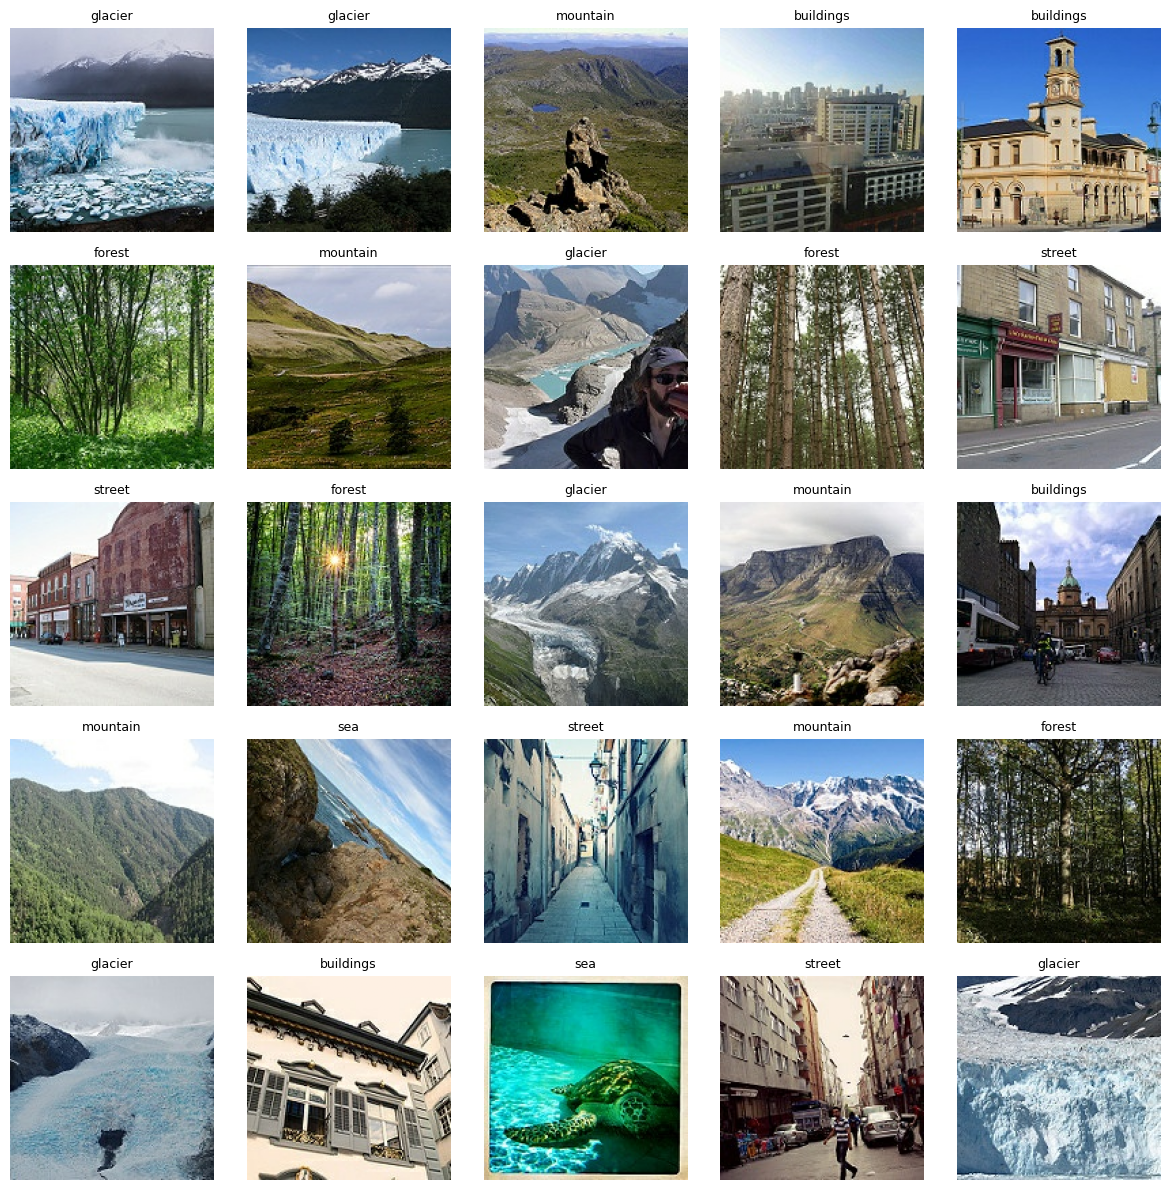

In [7]:
# Show 25 sample images

plt.figure(figsize=(12, 12))

# Take one batch from the dataset
images, labels = next(iter(train_ds))

for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(images[i].numpy())
    plt.title(class_names[int(labels[i])], fontsize=9)
    plt.axis("off")

plt.tight_layout()
plt.show()


### Prelude: Baseline CNN (reference model)

This is our **reference** network: two Conv→Pool blocks with channels **32 → 64**, followed by a **single hidden head** `Dense(64)`. We use **He** initialization for ReLU activations and include an **optional `Dropout(0.5)`** to illustrate regularization—comment it out to gauge its impact (ha, not really optional!).

Use this model as a stable yardstick while you run **ablations**: change **one knob at a time** (e.g., widen/deepen the conv blocks, adjust dropout rate, add batch norm, tweak the LR schedule) and compare results back to this baseline. Focus on **training vs. validation curves**, the **generalization gap**, and how dropout affects **val loss/accuracy** and how long it takes for Early Stopping to kick in.


**Warning:** Sometimes I get this, I think because it has exploding gradients; if you run it again, it generally disappears....

![Screenshot 2025-09-20 at 12.34.00 PM.png](attachment:c750862e-b0c8-405f-ae87-323064e42737.png)


Baseline Model



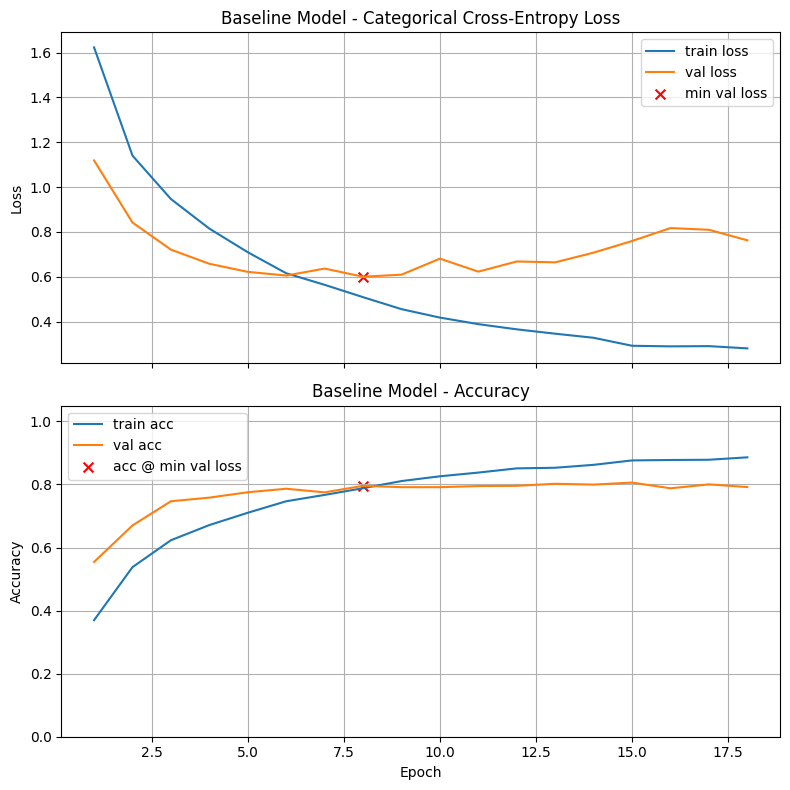

Final Training Loss:            0.2806
Final Training Accuracy:        0.8860
Final Validation Loss:          0.7626
Final Validation Accuracy:      0.7917
Minimum Validation Loss:        0.6003 (Epoch 8)
Validation Accuracy @ Min Loss: 0.7956

Test Loss: 0.6349
Test Accuracy: 0.7967

Validation-Test Gap (accuracy): 0.001018

Execution Time: 00:02:24


In [8]:
he = initializers.HeNormal()                                # best initializer for relu

model_baseline= models.Sequential([
    Input(shape=INPUT_SHAPE),

    Conv2D(32, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    MaxPooling2D(2),

    Conv2D(64, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    MaxPooling2D(2),

    Flatten(),
    Dense(64, activation="relu",kernel_initializer=he),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])

train_and_test(model_baseline,title=f"Baseline Model")


## Problem One: Exploring Basic Hyperparameters

**Task:**
Copy the baseline CNN model into the next cell and experiment with basic hyperparameter changes. Your goal is to see whether small tweaks can improve validation accuracy (and hopefully speed up convergence or produce smoother training curves). You must **pick 3 of the following tweaks** and investigate their effect:

**Tweaks to Try:**

1. Adjust the learning rate (default for Adam is `1e-3`).
2. Change the width of the `Conv2D` layers (e.g., 64 → 128).
3. Add an extra `Conv2D` layer (e.g., stack 32 → 64 → 128).
4. Change the width of the `Dense(64 ...)` layer.
5. Add L2 regularization to the `Dense(64 ...)` layer (see the head of the network in Problem 5 for inspiration).  
6. Modify the dropout rate.
   
Observe the effect of each of your 3 choices in isolation and answer the graded questions.

**Optional:**
Combine two or more changes to see if they work together to improve results (example: try L2 regularization and reduced dropout in the head, as in Problem 5).


**Pro Tip:** Give each experiment a descriptive title, such as "Problem 1 -- Tweak 1 -- lr: 0.0005" to keep track of your experiments (see last cell in the notebook).


Model One - 2



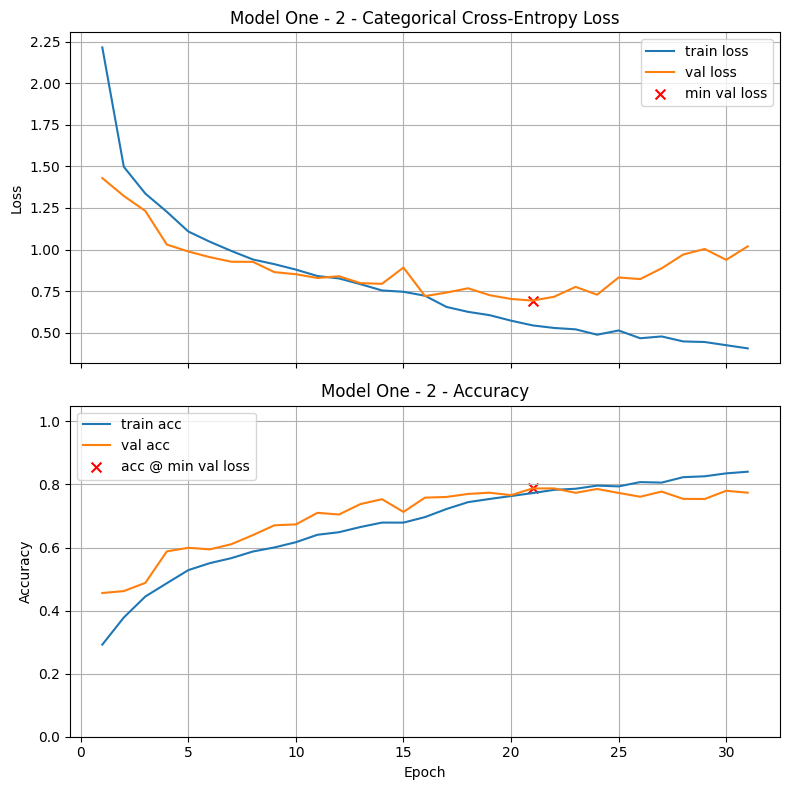

Final Training Loss:            0.4057
Final Training Accuracy:        0.8404
Final Validation Loss:          1.0192
Final Validation Accuracy:      0.7739
Minimum Validation Loss:        0.6931 (Epoch 21)
Validation Accuracy @ Min Loss: 0.7874

Test Loss: 0.7504
Test Accuracy: 0.7893

Validation-Test Gap (accuracy): 0.001887

Execution Time: 00:05:34


In [9]:
# Your code here, add additional cells if you wish
he = initializers.HeNormal()                                # best initializer for relu

model_one_2= models.Sequential([
    Input(shape=INPUT_SHAPE),

    Conv2D(32, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    MaxPooling2D(2),

    Conv2D(128, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    MaxPooling2D(2),

    Flatten(),
    Dense(64, activation="relu",kernel_initializer=he),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])

train_and_test(model_one_2,title=f"Model One - 2")



Model One - 3



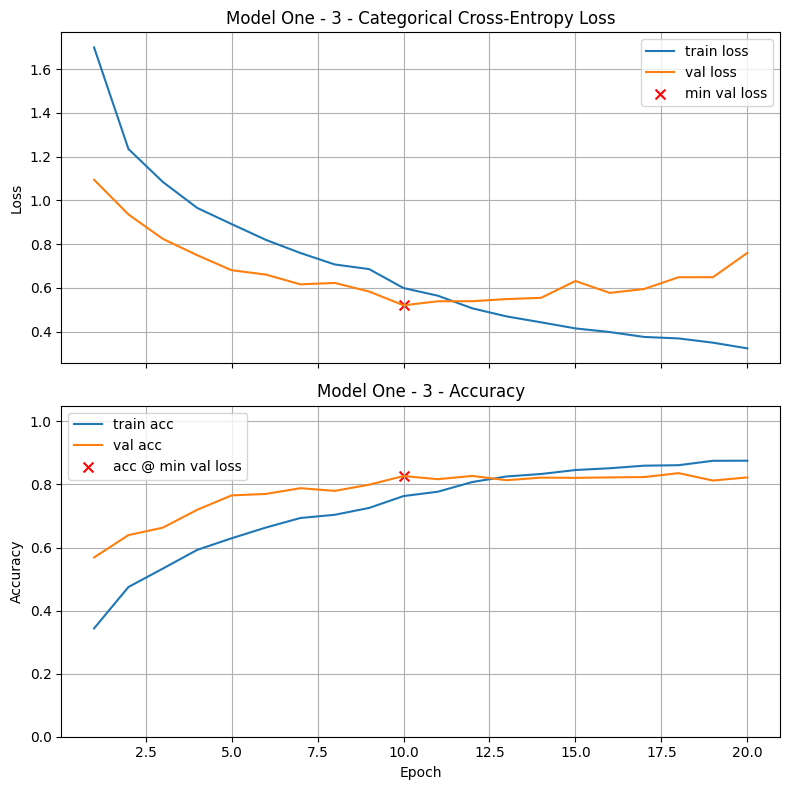

Final Training Loss:            0.3227
Final Training Accuracy:        0.8753
Final Validation Loss:          0.7598
Final Validation Accuracy:      0.8224
Minimum Validation Loss:        0.5199 (Epoch 10)
Validation Accuracy @ Min Loss: 0.8267

Test Loss: 0.5660
Test Accuracy: 0.8210

Validation-Test Gap (accuracy): 0.005676

Execution Time: 00:03:07


In [10]:
he = initializers.HeNormal()                                # best initializer for relu

model_one_3= models.Sequential([
    Input(shape=INPUT_SHAPE),

    Conv2D(32, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    MaxPooling2D(2),

    Conv2D(64, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    MaxPooling2D(2),

    Conv2D(128, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    MaxPooling2D(2),

    Flatten(),
    Dense(64, activation="relu",kernel_initializer=he),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])

train_and_test(model_one_3,title=f"Model One - 3")

In [11]:
he = initializers.HeNormal()                                # best initializer for relu

model_one_5= models.Sequential([
    Input(shape=INPUT_SHAPE),

    Conv2D(32, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    MaxPooling2D(2),

    Conv2D(64, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    MaxPooling2D(2),

    Flatten(),
    Dense(64, activation="relu",
          kernel_initializer=he,
          kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])

train_and_test(model_one_5,title=f"Model One - 5")


Model One - 5



Final Training Loss:            0.8686
Final Training Accuracy:        0.7364
Final Validation Loss:          0.7979
Final Validation Accuracy:      0.7899
Minimum Validation Loss:        0.7824 (Epoch 13)
Validation Accuracy @ Min Loss: 0.8006

Test Loss: 0.8180
Test Accuracy: 0.8020

Validation-Test Gap (accuracy): 0.001358

Execution Time: 00:02:52


### Graded Questions

In [12]:
# Set a1a to the number of the individual "tweak" which provided the best validation accuracy at the epoch of minimum validation loss

a1a = 3             # Replace with integer 1 - 6; replace with 0 if you found no tweak which improved the results

In [13]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a1a = {a1a}')


a1a = 3


In [14]:
# Set a1b to the validation accuracy found by the choice specified in Question a1a.

a1b = 0.8267             # Replace 0.0 with your answer

In [15]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a1b = {a1b:.4f}')

a1b = 0.8267


## Problem Two: Adding Batch Normalization

**Task:**
Take your best model from Problem One and add a `BatchNormalization()` layer immediately after each `Conv2D` layer. Batch normalization helps stabilize training and can improve convergence.

**Next Steps:**

* Train the model with batch normalization included after each `Conv2D` layer.
* Try at least one of tweaks from Problem 1 to see if you can improve your results in this new design.
* Compare the results to your earlier experiments and answer the graded questions.

**Optional:**
Try more than one hyperparameter change alongside batch normalization and see how they interact.




Model Two



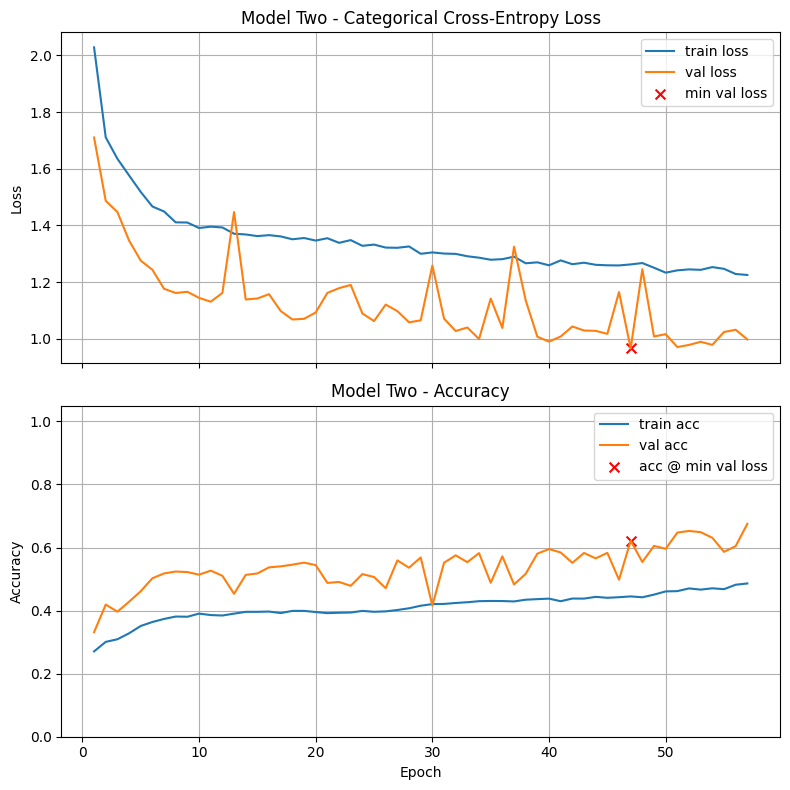

Final Training Loss:            1.2255
Final Training Accuracy:        0.4860
Final Validation Loss:          0.9981
Final Validation Accuracy:      0.6751
Minimum Validation Loss:        0.9667 (Epoch 47)
Validation Accuracy @ Min Loss: 0.6216

Test Loss: 0.9817
Test Accuracy: 0.6090

Validation-Test Gap (accuracy): 0.012612

Execution Time: 00:10:23


In [18]:
# Your code here, add additional cells if you wish
he = initializers.HeNormal()                                # best initializer for relu

model_two= models.Sequential([
    Input(shape=INPUT_SHAPE),

    Conv2D(32, (3,3), kernel_initializer=he, padding="same"),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(2),

    Conv2D(64, (3,3), kernel_initializer=he, padding="same"),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(2),

    Conv2D(128, (3,3), kernel_initializer=he, padding="same"),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(2),

    Flatten(),
    Dense(64, activation="relu",kernel_initializer=he,
          kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])

train_and_test(model_two,title=f"Model Two")


### Graded Questions

In [19]:
# Set a2a to the number of the individual "tweak" which provided the best validation accuracy at the epoch of minimum validation loss

a2a = 5             # Replace with integer 1 - 6; replace with 0 if you found no tweak which improved the results

In [20]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a2a = {a2a}')


a2a = 5


In [21]:
# Set a2b to the validation accuracy found by the choice specified in Question a2a (your best model for this problem)

a2b = 0.6216             # Replace 0.0 with your answer

In [22]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a2b = {a2b:.4f}')

a2b = 0.6216


## Problem Three: Global Average Pooling

As we saw in this week's Coding Video,
**Global Average Pooling** is a simple layer that replaces the `Flatten → Dense` part of a CNN (please review that part of the Coding Notebook, which contains a description of this important technique).

In practice, swapping `Flatten` for `GlobalAveragePooling2D` often improves stability and validation performance — definitely worth considering!


**Task:**
Modify your best model from Problems 1 & 2 to use a `GlobalAveragePooling2D()` layer instead of a flatten-and-dense block.

**Next Steps:**

* Replace the sequence between the last `Conv2D` and output layers, for example:

     
          MaxPooling2D((2, 2)),
          Flatten(),
          Dense(64, activation='relu', kernel_initializer=initializers.HeNormal()),
          Dropout(0.5),   

  with a single `GlobalAveragePooling2D()` layer.
* Train the model and observe how performance and training curves change.
* Try at least one of tweaks from Problem 1 to see if you can improve your results in this new design.
* Compare results and answer the graded questions.

**Optional:**
Experiment with `GlobalMaxPooling2D()` as an alternative and compare its behavior to `GlobalAveragePooling2D()`.




Model Three



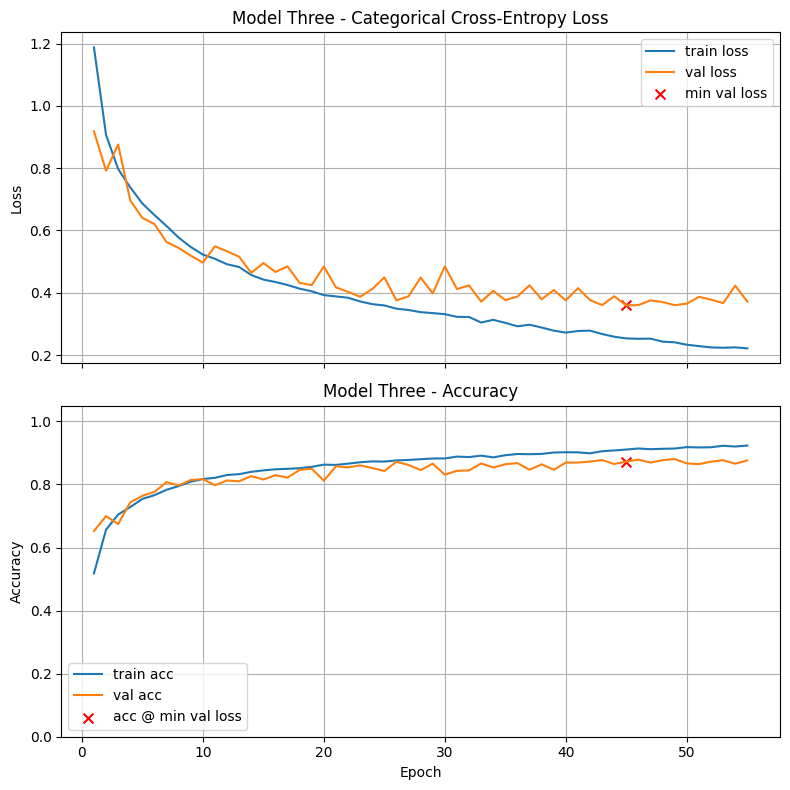

Final Training Loss:            0.2217
Final Training Accuracy:        0.9234
Final Validation Loss:          0.3717
Final Validation Accuracy:      0.8762
Minimum Validation Loss:        0.3593 (Epoch 45)
Validation Accuracy @ Min Loss: 0.8727

Test Loss: 0.3726
Test Accuracy: 0.8720

Validation-Test Gap (accuracy): 0.000682

Execution Time: 00:08:08


In [23]:
# Your code here, add additional cells if you wish
he = initializers.HeNormal()                                # best initializer for relu

model_three= models.Sequential([
    Input(shape=INPUT_SHAPE),

    Conv2D(32, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    MaxPooling2D(2),

    Conv2D(64, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    MaxPooling2D(2),

    Conv2D(128, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    MaxPooling2D(2),

    GlobalAveragePooling2D(),

    Dense(num_classes, activation="softmax")
])

train_and_test(model_three,title=f"Model Three")



Model Three - 2



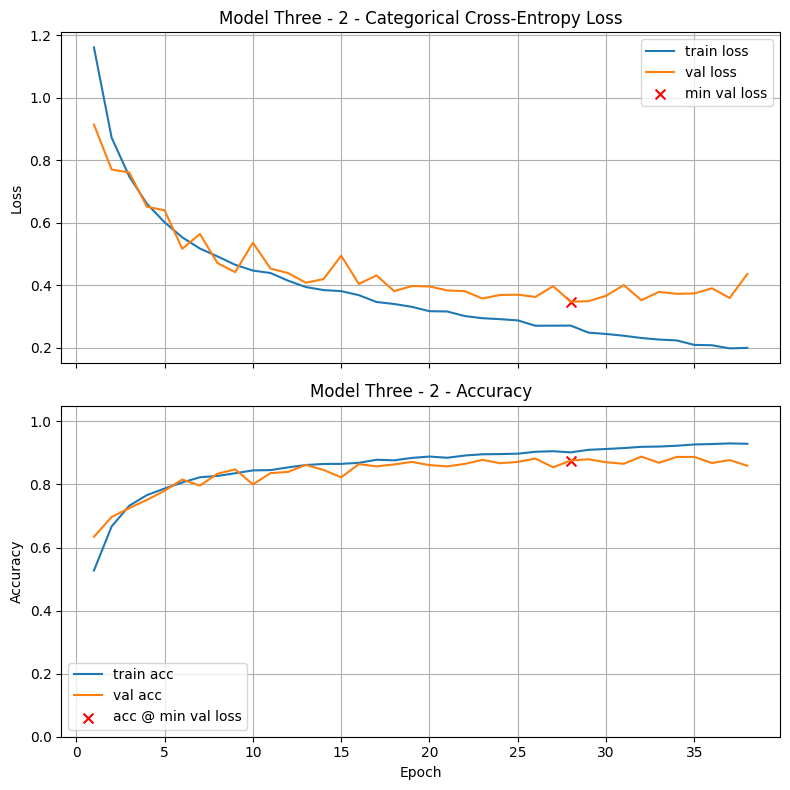

Final Training Loss:            0.1993
Final Training Accuracy:        0.9289
Final Validation Loss:          0.4357
Final Validation Accuracy:      0.8595
Minimum Validation Loss:        0.3470 (Epoch 28)
Validation Accuracy @ Min Loss: 0.8759

Test Loss: 0.3567
Test Accuracy: 0.8757

Validation-Test Gap (accuracy): 0.000225

Execution Time: 00:10:30


In [24]:
# Your code here, add additional cells if you wish
he = initializers.HeNormal()                                # best initializer for relu

model_three_2= models.Sequential([
    Input(shape=INPUT_SHAPE),

    Conv2D(32, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    MaxPooling2D(2),

    Conv2D(128, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    MaxPooling2D(2),

    Conv2D(256, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    MaxPooling2D(2),

    GlobalAveragePooling2D(),

    Dense(num_classes, activation="softmax")
])

train_and_test(model_three_2,title=f"Model Three - 2")


### Graded Questions

In [25]:
# Set a3a to the number of the individual "tweak" which provided the best validation accuracy at the epoch of minimum validation loss

a3a = 2             # Replace with integer 1 - 6; replace with 0 if you found no tweak which improved the results

In [26]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a3a = {a3a}')


a3a = 2


In [27]:
# Set a3b to the validation accuracy found by the choice specified in Question a3a (your best model for this problem)

a3b = 0.8759             # Replace 0.0 with your answer

In [28]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a3b = {a3b:.4f}')

a3b = 0.8759


## Problem Four: ReduceLROnPlateau

`ReduceLROnPlateau` is a widely used learning rate scheduling technique. It monitors a validation metric (usually `val_loss`) and reduces the learning rate when progress stalls, allowing the model to refine training at a smaller step size. This is one of the most useful scheduling tools (along with the essential Early Stopping) to have in your toolbox.

**Task:**
Augment your best model found so far in Problems 1 - 3 with the `ReduceLROnPlateau` callback during training.

**Next Steps:**

* Add the callback parameter to `train_and_test`:

  ```python
  callbacks=[reduce_lr]
  ```

* Start with **`factor=0.5`** (monitor `val_loss`, `patience=2–3`, `cooldown=1`, `min_lr=1e-5` for Adam).
* **Practical playbook:**

  * If plateau persists after one reduction → try **`factor=0.3`**, then **`0.2`**.
  * If a reduction hurts validation noticeably → try **`factor=0.7–0.8`** or increase **`patience`**.
  * Leave **`cooldown=1`** unless you see too-frequent drops.
* Experiment with **`patience` = 3, 5, 8** and **`min_delta` = `1e-4` vs `1e-3`** to gauge sensitivity.
* Choose the configuration with the best validation results—or note that ReduceLROnPlateau didn’t help (rare!).
* Answer the graded questions.




Model Four


Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 19: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 27: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 32: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 38: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 41: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.

Epoch 45: ReduceLROnPlateau reducing learning rate to 1e-05.


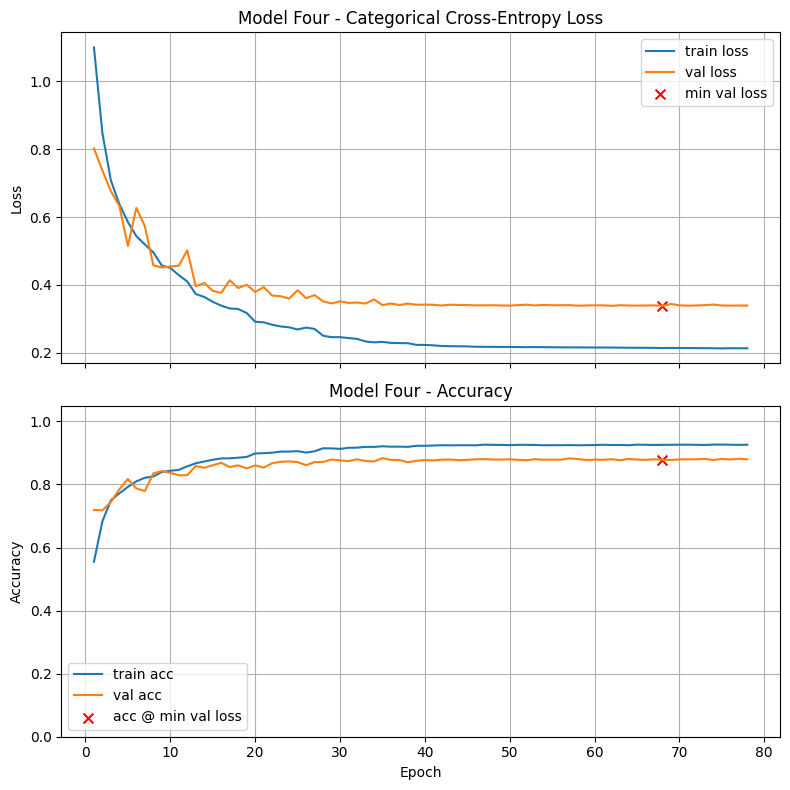

Final Training Loss:            0.2135
Final Training Accuracy:        0.9260
Final Validation Loss:          0.3394
Final Validation Accuracy:      0.8798
Minimum Validation Loss:        0.3385 (Epoch 68)
Validation Accuracy @ Min Loss: 0.8784

Test Loss: 0.3412
Test Accuracy: 0.8830

Validation-Test Gap (accuracy): 0.004612

Execution Time: 00:21:32


In [30]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',    # Quantity to be monitored.
    factor=0.5,            # Factor by which the learning rate will be reduced.
                           # new_lr = lr * factor
    patience=3,            # Number of epochs with no improvement
                           # after which learning rate will be reduced.
    min_delta=1e-4,        # Threshold for measuring the new optimum,
                           # to only focus on significant changes.
    cooldown=1,            # Number of epochs to wait before resuming
                           # normal operation after lr has been reduced.
    min_lr=1e-5,           # Lower bound on the learning rate.
    verbose=1,             # 0: quiet, 1: update messages.
)

he = initializers.HeNormal()                                # best initializer for relu

model_four= models.Sequential([
    Input(shape=INPUT_SHAPE),

    Conv2D(32, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    MaxPooling2D(2),

    Conv2D(128, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    MaxPooling2D(2),

    Conv2D(256, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    MaxPooling2D(2),

    GlobalAveragePooling2D(),

    Dense(num_classes, activation="softmax")
])

train_and_test(model_four,title=f"Model Four",callbacks=[reduce_lr])



Model Four - 0.3 Factor


Epoch 19: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.

Epoch 32: ReduceLROnPlateau reducing learning rate to 0.0001.


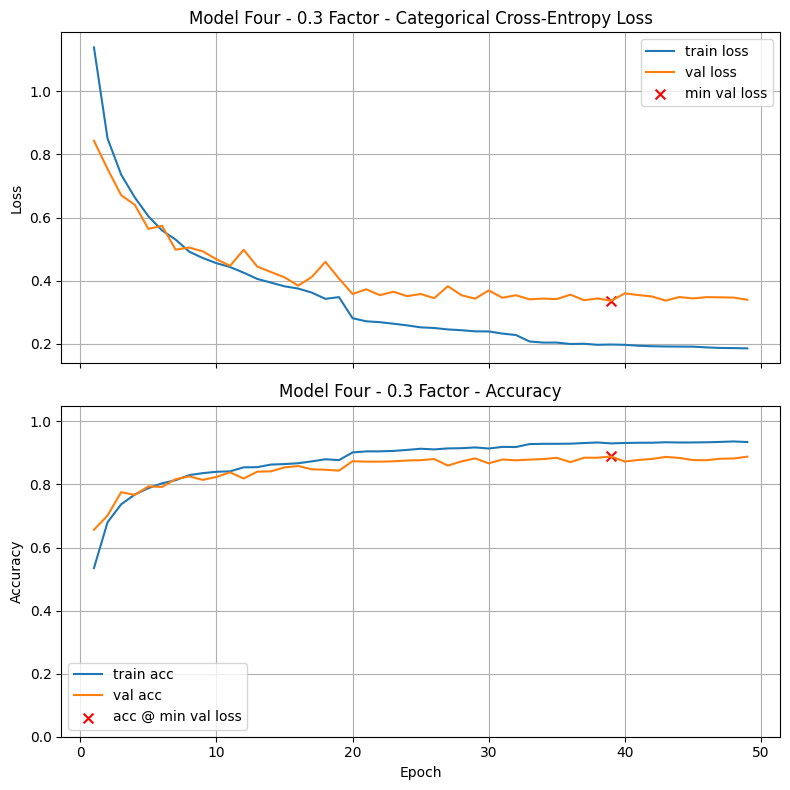

Final Training Loss:            0.1861
Final Training Accuracy:        0.9345
Final Validation Loss:          0.3400
Final Validation Accuracy:      0.8880
Minimum Validation Loss:        0.3367 (Epoch 39)
Validation Accuracy @ Min Loss: 0.8887

Test Loss: 0.3399
Test Accuracy: 0.8860

Validation-Test Gap (accuracy): 0.002730

Execution Time: 00:13:28


In [31]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',    # Quantity to be monitored.
    factor=0.3,            # Factor by which the learning rate will be reduced.
                           # new_lr = lr * factor
    patience=3,            # Number of epochs with no improvement
                           # after which learning rate will be reduced.
    min_delta=1e-4,        # Threshold for measuring the new optimum,
                           # to only focus on significant changes.
    cooldown=1,            # Number of epochs to wait before resuming
                           # normal operation after lr has been reduced.
    min_lr=1e-4,           # Lower bound on the learning rate.
    verbose=1,             # 0: quiet, 1: update messages.
)

he = initializers.HeNormal()                                # best initializer for relu

model_four_p3= models.Sequential([
    Input(shape=INPUT_SHAPE),

    Conv2D(32, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    MaxPooling2D(2),

    Conv2D(128, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    MaxPooling2D(2),

    Conv2D(256, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    MaxPooling2D(2),

    GlobalAveragePooling2D(),

    Dense(num_classes, activation="softmax")
])

train_and_test(model_four_p3,title=f"Model Four - 0.3 Factor",callbacks=[reduce_lr])


### Graded Questions

In [32]:
# Set a4a to the factor parameter which gave the best validation accuracy at the point of minimum validation loss

a4a = 0.3             # Replace with your best factor value, or leave at 0.0 if reduce on plateau did not help at all

In [33]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a4a = {a4a:.2f}')

a4a = 0.30


In [34]:
# Set a4b to the validation accuracy found by the choice specified in Question a4a (your best model for this problem)

a4b = 0.8887             # Replace 0.0 with your answer

In [35]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a4b = {a4b:.4f}')

a4b = 0.8887


## Problem Five: A Very Deep CNN (VGG-16 Style)

 We will now experiment with the VGG-16 design introduced in the Coding Notebook and Video and see how it does on this dataset. For a beautiful description of the model and its significance, see [Explanation of VGG-16](https://viso.ai/deep-learning/vgg-very-deep-convolutional-networks/) :
        

![Screenshot 2025-09-19 at 6.50.24 AM.png](attachment:62fa0824-bb06-4663-a6a5-da8cca8f4ab3.png)


In this exercise you’ll **only vary the learning rate**. Don’t change any other hyperparameters. Your goal is to observe how LR affects convergence speed, stability, and final validation performance compared to your smaller baselines. This sets up next week’s **transfer learning** with pretrained models.

#### Starting point

* Optimizer: **Adam**
* **Recommended LR to start:** `1e-3`(Adam default)

#### What LR values to try (coarse → fine)

Try a short sweep like:

```
[1e-2, 3e-3, 1e-3, 3e-4, 1e-4, 3e-5, 1e-5]
```

Then, as time allows,  zoom in around the best.

#### How to judge “best”

* Primary: **best validation accuracy at epoch of lowest validation loss**
* Secondary: **time-to-best** (fewer epochs to reach a strong val metric) and **curve shape** (smooth vs. noisy/oscillatory).

#### What symptoms mean

* **LR too high:** training loss spikes or oscillates; val metrics erratic, occasional NaNs/divergence.
* **LR too low:** very slow improvement; long flat regions; never reaches your smaller models’ performance.


**Tip:** Keep LR **constant** during each run (don’t schedule) so you isolate its effect.




Model Five - 1e-3



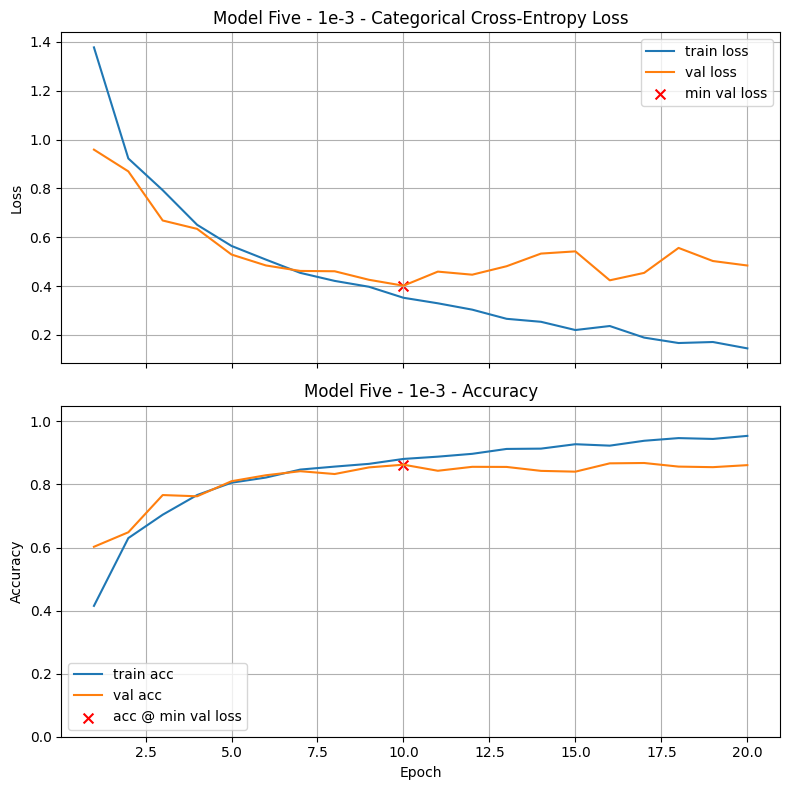

Final Training Loss:            0.1452
Final Training Accuracy:        0.9541
Final Validation Loss:          0.4846
Final Validation Accuracy:      0.8613
Minimum Validation Loss:        0.4018 (Epoch 10)
Validation Accuracy @ Min Loss: 0.8627

Test Loss: 0.3970
Test Accuracy: 0.8647

Validation-Test Gap (accuracy): 0.001970

Execution Time: 00:31:58


In [36]:
he = initializers.HeNormal()
l2reg = regularizers.l2(1e-4)   # set to None to disable or tweak the value

model_vgg_16 = models.Sequential([
    layers.Input(shape=(150, 150, 3)),

    # Block 1
    layers.Conv2D(64, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.Conv2D(64, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.MaxPooling2D(),

    # Block 2
    layers.Conv2D(128, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.Conv2D(128, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.MaxPooling2D(),

    # Block 3
    layers.Conv2D(256, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.Conv2D(256, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.Conv2D(256, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.MaxPooling2D(),

    # Block 4 (NO MaxPool here -> leaves 3×3×512)
    layers.Conv2D(512, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.Conv2D(512, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.Conv2D(512, (3,3), padding='same', activation='relu', kernel_initializer=he),

    # Global pooling meaningfully summarizes the 3×3 map
    layers.GlobalAveragePooling2D(),   # swap to GlobalMaxPooling2D() to compare

    # Compact head
    layers.Dense(256, activation='relu', kernel_initializer=he,
                 kernel_regularizer=l2reg),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

# Uncomment the next line to run

train_and_test(model_vgg_16,lr_schedule=1e-3,title="Model Five - 1e-3")


In [39]:
he = initializers.HeNormal()
l2reg = regularizers.l2(1e-4)   # set to None to disable or tweak the value

model_vgg_16_2 = models.Sequential([
    layers.Input(shape=(150, 150, 3)),

    # Block 1
    layers.Conv2D(64, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.Conv2D(64, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.MaxPooling2D(),

    # Block 2
    layers.Conv2D(128, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.Conv2D(128, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.MaxPooling2D(),

    # Block 3
    layers.Conv2D(256, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.Conv2D(256, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.Conv2D(256, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.MaxPooling2D(),

    # Block 4 (NO MaxPool here -> leaves 3×3×512)
    layers.Conv2D(512, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.Conv2D(512, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.Conv2D(512, (3,3), padding='same', activation='relu', kernel_initializer=he),

    # Global pooling meaningfully summarizes the 3×3 map
    layers.GlobalAveragePooling2D(),   # swap to GlobalMaxPooling2D() to compare

    # Compact head
    layers.Dense(256, activation='relu', kernel_initializer=he,
                 kernel_regularizer=l2reg),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

# Uncomment the next line to run

train_and_test(model_vgg_16_2,lr_schedule=1e-2,title="Model Five - 1e-2",verbose=1, epochs=200)



Model Five - 1e-2

Epoch 1/200
351/351 ━━━━━━━━━━━━━━━━━━━━ 97s 258ms/step - accuracy: 0.1758 - loss: 31359.9453 - val_accuracy: 0.1790 - val_loss: 1.8249
Epoch 2/200
351/351 ━━━━━━━━━━━━━━━━━━━━ 86s 244ms/step - accuracy: 0.1731 - loss: 1.8246 - val_accuracy: 0.1790 - val_loss: 1.8210
Epoch 3/200
351/351 ━━━━━━━━━━━━━━━━━━━━ 86s 244ms/step - accuracy: 0.1809 - loss: 1.8205 - val_accuracy: 0.1712 - val_loss: 1.8183
Epoch 4/200
351/351 ━━━━━━━━━━━━━━━━━━━━ 86s 244ms/step - accuracy: 0.1730 - loss: 1.8181 - val_accuracy: 0.1790 - val_loss: 1.8171
Epoch 5/200
351/351 ━━━━━━━━━━━━━━━━━━━━ 86s 244ms/step - accuracy: 0.1747 - loss: 1.8178 - val_accuracy: 0.1790 - val_loss: 1.8162
Epoch 6/200
351/351 ━━━━━━━━━━━━━━━━━━━━ 86s 244ms/step - accuracy: 0.1842 - loss: 1.8159 - val_accuracy: 0.1790 - val_loss: 1.8159
Epoch 7/200
351/351 ━━━━━━━━━━━━━━━━━━━━ 86s 244ms/step - accuracy: 0.1818 - loss: 1.8154 - val_accuracy: 0.1790 - val_loss: 1.8148
Epoch 8/200
351/351 ━━━━━━━━━━━━━━━━━━━━ 86s 244ms/s

KeyboardInterrupt: 


Model Five - 1e-4

Epoch 1/200
351/351 ━━━━━━━━━━━━━━━━━━━━ 109s 294ms/step - accuracy: 0.4023 - loss: 1.4568 - val_accuracy: 0.6216 - val_loss: 0.9769
Epoch 2/200
351/351 ━━━━━━━━━━━━━━━━━━━━ 100s 286ms/step - accuracy: 0.6420 - loss: 0.9548 - val_accuracy: 0.6876 - val_loss: 0.9058
Epoch 3/200
351/351 ━━━━━━━━━━━━━━━━━━━━ 101s 288ms/step - accuracy: 0.7373 - loss: 0.7870 - val_accuracy: 0.7792 - val_loss: 0.6326
Epoch 4/200
351/351 ━━━━━━━━━━━━━━━━━━━━ 101s 287ms/step - accuracy: 0.7736 - loss: 0.6643 - val_accuracy: 0.7967 - val_loss: 0.6282
Epoch 5/200
351/351 ━━━━━━━━━━━━━━━━━━━━ 101s 288ms/step - accuracy: 0.8072 - loss: 0.5881 - val_accuracy: 0.8135 - val_loss: 0.5362
Epoch 6/200
351/351 ━━━━━━━━━━━━━━━━━━━━ 101s 288ms/step - accuracy: 0.8281 - loss: 0.5249 - val_accuracy: 0.8434 - val_loss: 0.4866
Epoch 7/200
351/351 ━━━━━━━━━━━━━━━━━━━━ 101s 287ms/step - accuracy: 0.8462 - loss: 0.4679 - val_accuracy: 0.8513 - val_loss: 0.4718
Epoch 8/200
351/351 ━━━━━━━━━━━━━━━━━━━━ 100s 286

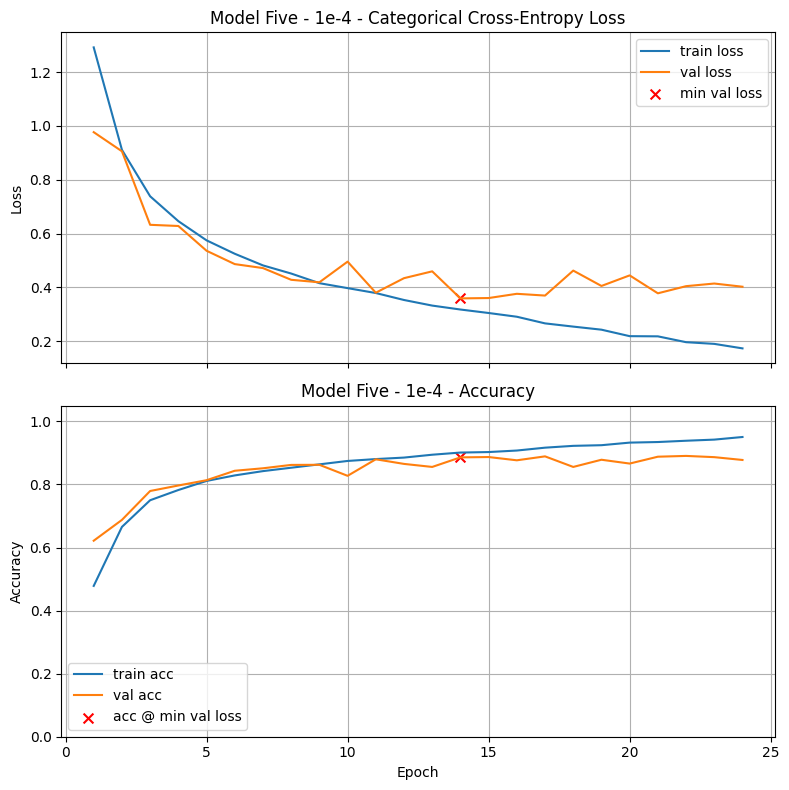

Final Training Loss:            0.1734
Final Training Accuracy:        0.9505
Final Validation Loss:          0.4025
Final Validation Accuracy:      0.8777
Minimum Validation Loss:        0.3592 (Epoch 14)
Validation Accuracy @ Min Loss: 0.8859

Test Loss: 0.3683
Test Accuracy: 0.8823

Validation-Test Gap (accuracy): 0.003544

Execution Time: 00:40:34


In [38]:
he = initializers.HeNormal()
l2reg = regularizers.l2(1e-4)   # set to None to disable or tweak the value

model_vgg_16_4 = models.Sequential([
    layers.Input(shape=(150, 150, 3)),

    # Block 1
    layers.Conv2D(64, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.Conv2D(64, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.MaxPooling2D(),

    # Block 2
    layers.Conv2D(128, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.Conv2D(128, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.MaxPooling2D(),

    # Block 3
    layers.Conv2D(256, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.Conv2D(256, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.Conv2D(256, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.MaxPooling2D(),

    # Block 4 (NO MaxPool here -> leaves 3×3×512)
    layers.Conv2D(512, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.Conv2D(512, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.Conv2D(512, (3,3), padding='same', activation='relu', kernel_initializer=he),

    # Global pooling meaningfully summarizes the 3×3 map
    layers.GlobalAveragePooling2D(),   # swap to GlobalMaxPooling2D() to compare

    # Compact head
    layers.Dense(256, activation='relu', kernel_initializer=he,
                 kernel_regularizer=l2reg),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

# Uncomment the next line to run

train_and_test(model_vgg_16_4,lr_schedule=1e-4,title="Model Five - 1e-4",verbose=1, epochs=200)


Model Five - 1e-5

Epoch 1/200
351/351 ━━━━━━━━━━━━━━━━━━━━ 110s 297ms/step - accuracy: 0.3773 - loss: 1.5323 - val_accuracy: 0.6020 - val_loss: 1.0465
Epoch 2/200
351/351 ━━━━━━━━━━━━━━━━━━━━ 101s 288ms/step - accuracy: 0.5823 - loss: 1.0962 - val_accuracy: 0.6772 - val_loss: 0.9587
Epoch 3/200
351/351 ━━━━━━━━━━━━━━━━━━━━ 101s 289ms/step - accuracy: 0.6607 - loss: 0.9401 - val_accuracy: 0.7297 - val_loss: 0.8118
Epoch 4/200
351/351 ━━━━━━━━━━━━━━━━━━━━ 101s 289ms/step - accuracy: 0.7018 - loss: 0.8505 - val_accuracy: 0.7361 - val_loss: 0.7564
Epoch 5/200
351/351 ━━━━━━━━━━━━━━━━━━━━ 101s 288ms/step - accuracy: 0.7215 - loss: 0.8161 - val_accuracy: 0.6912 - val_loss: 0.8185
Epoch 6/200
351/351 ━━━━━━━━━━━━━━━━━━━━ 101s 288ms/step - accuracy: 0.7399 - loss: 0.7633 - val_accuracy: 0.7785 - val_loss: 0.6488
Epoch 7/200
351/351 ━━━━━━━━━━━━━━━━━━━━ 101s 288ms/step - accuracy: 0.7567 - loss: 0.7241 - val_accuracy: 0.7782 - val_loss: 0.6729
Epoch 8/200
351/351 ━━━━━━━━━━━━━━━━━━━━ 101s 288

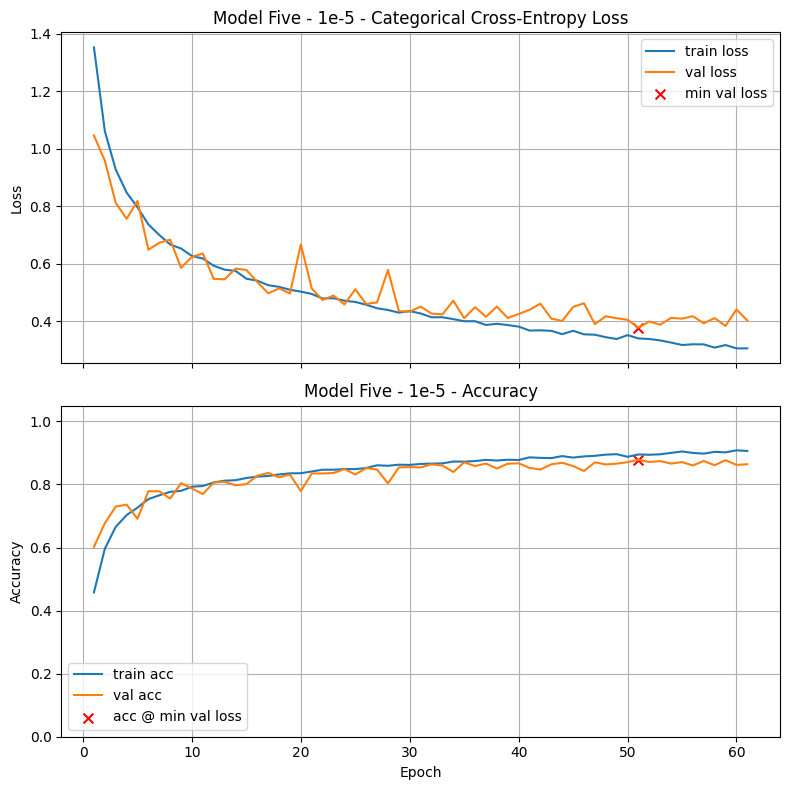

Final Training Loss:            0.3052
Final Training Accuracy:        0.9062
Final Validation Loss:          0.4023
Final Validation Accuracy:      0.8641
Minimum Validation Loss:        0.3776 (Epoch 51)
Validation Accuracy @ Min Loss: 0.8784

Test Loss: 0.3838
Test Accuracy: 0.8800

Validation-Test Gap (accuracy): 0.001612

Execution Time: 01:43:19


In [40]:
he = initializers.HeNormal()
l2reg = regularizers.l2(1e-4)   # set to None to disable or tweak the value

model_vgg_16_5 = models.Sequential([
    layers.Input(shape=(150, 150, 3)),

    # Block 1
    layers.Conv2D(64, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.Conv2D(64, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.MaxPooling2D(),

    # Block 2
    layers.Conv2D(128, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.Conv2D(128, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.MaxPooling2D(),

    # Block 3
    layers.Conv2D(256, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.Conv2D(256, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.Conv2D(256, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.MaxPooling2D(),

    # Block 4 (NO MaxPool here -> leaves 3×3×512)
    layers.Conv2D(512, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.Conv2D(512, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.Conv2D(512, (3,3), padding='same', activation='relu', kernel_initializer=he),

    # Global pooling meaningfully summarizes the 3×3 map
    layers.GlobalAveragePooling2D(),   # swap to GlobalMaxPooling2D() to compare

    # Compact head
    layers.Dense(256, activation='relu', kernel_initializer=he,
                 kernel_regularizer=l2reg),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

# Uncomment the next line to run

train_and_test(model_vgg_16_5,lr_schedule=1e-5,title="Model Five - 1e-5",verbose=1, epochs=200)

### Graded Questions

In [41]:
# Set a5a to the learning rate which gave the best validation accuracy at the point of minimum validation loss

a5a = 1e-4             # Replace with your best learning rate

In [42]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a5a = {a5a:.8f}')

a5a = 0.00010000


In [43]:
# Set a5b to the validation accuracy found by the choice specified in Question a5a (your best model for this problem)

a5b = 0.8859              # Replace 0.0 with your answer

In [44]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a5b = {a5b:.4f}')

a5b = 0.8859


## All Results

This will print out the results from all experiments, with titles as keys. I use this all the time to keep track of experiments!

In [45]:
print_results()

Model Four - 0.3 Factor                 	0.8887	39
Model Five - 1e-4                       	0.8859	14
Model Four                              	0.8784	68
Model Five - 1e-5                       	0.8784	51
Model Three - 2                         	0.8759	28
Model Three                             	0.8727	45
Model Five - 1e-3                       	0.8627	10
Model One - 3                           	0.8267	10
Model One - 5                           	0.8006	13
Baseline Model                          	0.7956	8
Model One - 2                           	0.7874	21
Model Two                               	0.6216	47


    VGG-style Large -- lr: 0.0001           	0.8700	18
    Model with ReduceLROnPlateau            	0.8636	227
    VGG-style Large -- lr: 0.0003           	0.8400	23
    VGG-style Large -- lr: 1e-05            	0.8301	60
    VGG-style Large -- lr: 3e-05            	0.8269	26
    Baseline model using BatchNormalization -- Tweak 2 -- 64 -> 128	0.8140	33
    Baseline Plus -- Tweaks 5 & 6 -- Do: 0.3	0.8030	50
    Baseline model using BatchNormalization -- Tweak 3 -- 32 -> 64 -> 128	0.8019	26
    Baseline model using BatchNormalization -- Tweak 4 -- Dense 128	0.7976	24
    Baseline model using BatchNormalization 	0.7941	7
    Baseline Plus -- Tweak 3 -- 32 -> 64 -> 128	0.7912	20
    Baseline Plus -- Tweak 6 -- Do: 0.3     	0.7745	36
    Baseline Plus -- Tweak 2 -- 64 -> 128   	0.7645	25
    Baseline Plus -- Tweak 5 -- L2: 1e-4    	0.7570	27
    Model using GAP                         	0.7553	10
    Baseline Plus -- Two Tweaks! -- L2: 1e-4 Do: 0.3	0.7506	19
    VGG-style Large -- lr: 0.001            	0.6865	5
    Baseline Plus -- Tweak 4 -- Dense 128   	0.5999	1
    Baseline Plus -- Tweak 1 -- lr: 1e-4    	0.4817	3
    Baseline model using BatchNormalization -- Tweak 1 lr: 0.0001 	0.3691	1
    VGG-style Large -- lr: 0.01             	0.1792	95
    VGG-style Large -- lr: 0.003            	0.1792	195
    Baseline Model                          	0.0000	1